In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2024-04-30 01:23:28.815652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 01:23:28.815762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 01:23:28.933899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
def load_data(csv_file, image_dir):
    # Loading the CSV file containing image identifiers and diagnosis confidences
    data = pd.read_csv(csv_file)
    
    # Initializing lists to store image paths and labels
    images = []
    labels = []
    # Iterating over each row in the CSV file
    for index, row in tqdm(data.iterrows(), total=len(data), desc="Loading Data"):
        image_id = row['image']
        # Get label confidences
        label_confidences = row.drop('image').to_dict()
        label_confidences = np.array([int(i) for i in label_confidences.values()])
        
        # Construct the path to the image file
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        
        # Check if the image file exists
        if os.path.exists(image_path):
            labels.append(label_confidences)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
        else:
            print(f"Image file not found: {image_path}")
    
    return (np.array(images)/255).astype(np.float32), np.array(labels)

In [18]:
train_images, train_labels = load_data('/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv', '/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input')

Loading Data: 100%|██████████| 10015/10015 [02:15<00:00, 74.02it/s]


In [9]:
test_images, test_labels = load_data('/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv', '/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Test_Input/ISIC2018_Task3_Test_Input')

Loading Data: 100%|██████████| 1512/1512 [00:25<00:00, 58.78it/s]


In [5]:
val_images, val_labels = load_data('/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv', '/kaggle/input/isic-2018-task-3/ISIC2018_Task3_Validation_Input/ISIC2018_Task3_Validation_Input')

Loading Data: 100%|██████████| 193/193 [00:03<00:00, 57.17it/s]


In [19]:
# Loading pretrained ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding your own dense layer for the desired output
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(train_labels[0]), activation='sigmoid')(x)

In [20]:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
checkpoint = ModelCheckpoint("unet_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, min_lr=0.0005, verbose=1, mode='max')

model.compile(optimizer=SGD(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels,batch_size = 32, epochs=100, validation_split = 0.2 ,callbacks=[checkpoint, early_stopping])

Epoch 1/100
  4/251 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.0990 - loss: 2.1608

W0000 00:00:1714440973.181353    3659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0866 - loss: 2.1325

W0000 00:00:1714440995.460402    3659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.21667, saving model to unet_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - accuracy: 0.0866 - loss: 2.1324 - val_accuracy: 0.2167 - val_loss: 1.9857
Epoch 2/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0878 - loss: 2.0341
Epoch 2: val_accuracy did not improve from 0.21667
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.0877 - loss: 2.0340 - val_accuracy: 0.2167 - val_loss: 1.9133
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0876 - loss: 1.9499
Epoch 3: val_accuracy did not improve from 0.21667
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.0876 - loss: 1.9498 - val_accuracy: 0.2167 - val_loss: 1.8463
Epoch 4/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1282 - loss: 1.8695
Epoch 4: val_accuracy improved from 0.21667 to 0.59810, saving model to unet_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.1294 - loss: 1.8694 - val_accuracy: 0.5981 

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_probs = model.predict(test_images)
test_preds = np.argmax(test_probs,axis=1)
test_labels_indices = np.argmax(test_labels,axis=1)

accuracy = accuracy_score(test_labels_indices, test_preds)
print(f"Accuracy: {accuracy:.4f}")

 5/48 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

W0000 00:00:1714441373.086242    3657 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step
Accuracy: 0.5952


In [10]:
print(test_probs[1],test_labels[1])

[0.6576344  0.9233439  0.45618773 0.36747748 0.6620516  0.2769947
 0.2850767 ] [0 1 0 0 0 0 0]


In [23]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

# Create a new model by adding your own dense layer for the desired output
x = Flatten()(vgg_model.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output_layer = Dense(7, activation='softmax')(x)

# Combine the base model and the new dense layer to create the final model
FT_model = Model(inputs=vgg_model.input, outputs=output_layer)

# Compile the model
FT_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the model
FT_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,289,223 (512.27 MB)

 Trainable params: 119,574,535 (456.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
checkpoint = ModelCheckpoint("unet_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
FT_model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

FT_history = FT_model.fit(train_images, train_labels, epochs=100, validation_split = 0.2,callbacks=[checkpoint, early_stopping])

Epoch 1/100
  2/251 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 1.0000 - loss: 0.0326

W0000 00:00:1714444938.226633    3659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9969 - loss: 0.0325

W0000 00:00:1714444959.014132    3657 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714444962.731227    3659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.64803, saving model to unet_model.keras


W0000 00:00:1714444967.200454    3659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - accuracy: 0.9969 - loss: 0.0325 - val_accuracy: 0.6480 - val_loss: 237.2899
Epoch 2/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9969 - loss: 0.0343
Epoch 2: val_accuracy did not improve from 0.64803
251/251 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.9969 - loss: 0.0342 - val_accuracy: 0.6460 - val_loss: 235.2115
Epoch 3/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9963 - loss: 0.0301
Epoch 3: val_accuracy did not improve from 0.64803
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.9963 - loss: 0.0301 - val_accuracy: 0.6480 - val_loss: 237.9019
Epoch 4/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9978 - loss: 0.0303
Epoch 4: val_accuracy did not improve from 0.64803
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.9978 - loss: 0.0303 - val_accuracy: 0.6425 - val_loss: 238.4184
Epoch 5/100
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9965 - loss: 0.0300
Epoch 5: v

In [34]:
test_probs = FT_model.predict(test_images)
test_preds = np.argmax(test_probs,axis=1)
test_labels_indices = np.argmax(test_labels,axis=1)

accuracy = accuracy_score(test_labels_indices, test_preds)
print(f"Accuracy: {accuracy:.4f}")

 4/48 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1714445584.394491    3657 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step
Accuracy: 0.7090


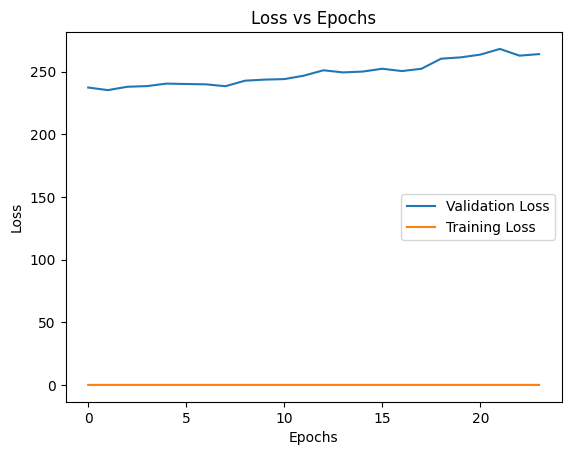

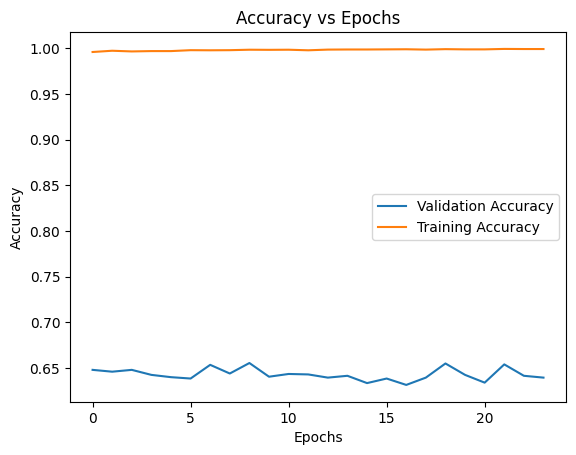

In [35]:
import matplotlib.pyplot as plt


plt.plot(FT_history.history['val_loss'], label='Validation Loss')
# Plot training loss vs epochs
plt.plot(FT_history.history['loss'], label='Training Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy vs epochs
plt.plot(FT_history.history['val_accuracy'], label='Validation Accuracy')
# Plot training accuracy vs epochs
plt.plot(FT_history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

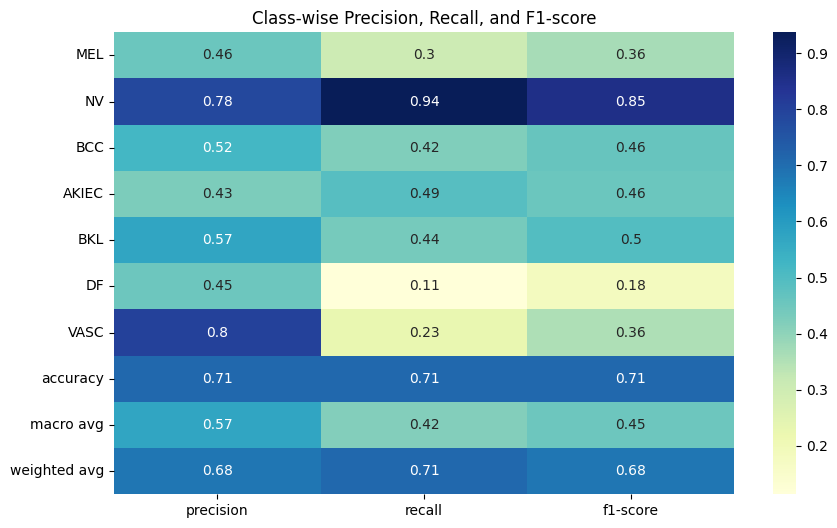

In [38]:
from sklearn.metrics import classification_report
import seaborn as sns
# Generate classification report
class_report = classification_report(test_labels_indices, test_preds, target_names=['MEL',
'NV',
'BCC',
'AKIEC',
'BKL',
'DF',
'VASC'
], output_dict=True)

# Convert to DataFrame for better visualization
class_report_df = pd.DataFrame(class_report).transpose()

# Plot precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu')
plt.title('Class-wise Precision, Recall, and F1-score')
plt.show()